In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import scipy.io as sio
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix, precision_recall_fscore_support
import timm
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn 
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
sep = '\\' if os.name == 'nt' else '/'

In [5]:
hiperparametros = {
    'epocas' : 50,
    'lr' : 0.001,
    'batch_size' : 64,
    'seed' : 56389856,
    'dropout' : 0.1
}


In [6]:
path_thorres = 'D:/MSc/img_bispectrum/test/bisp_thorres/'
path_abdo = 'D:/MSc/img_bispectrum/test/bisp_abdo/'
path_labels = 'D:/MSc/img_bispectrum/test/labels_img/'


In [7]:
files_thorres = glob.glob(path_thorres + '*')
files_abdo = glob.glob(path_abdo + '*')
files_labels = glob.glob(path_labels + '*')

In [8]:
len(files_thorres), len(files_abdo), len(files_labels)

(135366, 135366, 5000)

In [9]:
def search_and_order_files_of_subject(subject_name, files):
    
    lst = [path for path in files if subject_name in path]
    lista = [(path, eval(path.split('_')[-1].split('.')[0])) for path in lst]
    ordered_list = sorted(lista,  key=lambda x: x[1])
    
    return [element[0] for element in ordered_list]

In [10]:
def open_subject_labels(path):
    
    data = sio.loadmat(path)
    n_segments = data.get('n_segments')
    y_central_data = data.get('vec_all_central')
    y_hypopnea_data = data.get('vec_all_hypo')
    y_osa_data = data.get('vec_all_osa')
    y_events_data = data.get('vec_all_events')
    n_segments = data.get('n_segments')
    
    return y_central_data.squeeze(), y_hypopnea_data.squeeze(), y_osa_data.squeeze(), y_events_data.squeeze(), n_segments

In [11]:
class MyDatasetTest(Dataset):
    def __init__(self, label, subject_images_thorres, subject_images_abdo, y_events, y_central, y_osa, y_hypo) -> None:
        self.label = label
        self.subject_images_thorres = subject_images_thorres
        self.subject_images_abdo = subject_images_abdo
        self.y_events = y_events
        self.y_central = y_central
        self.y_osa = y_osa
        self.y_hypo = y_hypo
        
    def __getitem__(self, index):
        name_ind = self.label
        x_torres_ind = self.subject_images_thorres[index]
        x_abdo_ind = self.subject_images_abdo[index]
        y_events_ind = self.y_events[index]
        y_central_ind = self.y_central[index]
        y_hypo_ind = self.y_hypo[index]
        y_osa_ind = self.y_osa[index]

        thorres = torch.from_numpy(np.moveaxis(x_torres_ind / 255, -1, 0))
        abdores = torch.from_numpy(np.moveaxis(x_abdo_ind / 255, -1, 0))
        
        x = torch.cat([thorres, abdores], axis = 0)
        
        y = torch.Tensor([y_events_ind]).float()

        return x, y, name_ind

    def __len__(self):
        return len(self.subject_images_thorres)

In [12]:
model = timm.create_model('efficientnet_b1', pretrained=True, num_classes = 1, in_chans = 6).to(device)

model.load_state_dict(torch.load('C:/Users/marta/Desktop/TFM/test/efficientnet_b1_ridge.pth'))


<All keys matched successfully>

In [13]:
criterion = torch.nn.HuberLoss(reduction= "mean")

In [14]:
def get_AHI_pred_real(outputs, labels):
    AHI_pred = sum(outputs)/len(outputs)*3
    AHI_real = sum(labels)/len(labels)*3
    
    return AHI_pred, AHI_real

In [24]:
df = pd.DataFrame(columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])

In [26]:
for label in tqdm(files_labels):
    subject_name = label.split(sep)[-1].split('_')[1]
    subject_files_thorres = search_and_order_files_of_subject(subject_name, files_thorres)
    subject_files_abdo = search_and_order_files_of_subject(subject_name, files_abdo)
    subject_images_thorres = [np.array(Image.open(path)) for path in subject_files_thorres]
    subject_images_abdo = [np.array(Image.open(path)) for path in subject_files_abdo]
    y_central_data, y_hypopnea_data, y_osa_data, y_events_data, n_segments = open_subject_labels(label)

    dataset = MyDatasetTest(label, subject_images_thorres, subject_images_abdo,
                            y_events_data, y_central_data, y_osa_data, y_hypopnea_data)

    dataloader = DataLoader(dataset, batch_size= hiperparametros['batch_size'], shuffle= True)

    model.eval()    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels, names = data[0].to(device, dtype=torch.float32), data[1].to(device), data[2]
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            loss_medio_test = loss_val.item()
            AHI_pred_test, AHI_real_test = get_AHI_pred_real(outputs, labels)


    new_row = pd.DataFrame([[label.split('\\')[-1].split('_')[1], AHI_pred_test.item(), 
                             AHI_real_test.item(), loss_medio_test]], 
                           columns = ['Name', 'AHI_pred', 'AHI_real', 'loss_test'])
    
    
    df = pd.concat([df, new_row])
    
    

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [2:03:43<00:00,  1.48s/it]


In [27]:
df

,Name,AHI_pred,AHI_real,loss_test
0,shhs1-200078,22.892052,41.739132,6.270462
0,shhs1-200079,19.267197,21.130436,4.94388
0,shhs1-200081,14.967633,6.576923,4.006733
0,shhs1-200086,25.223133,13.5,3.4407
0,shhs1-200088,34.433849,39.409092,3.364005
...,...,...,...,...
0,shhs2-205785,21.519291,10.965517,4.369956
0,shhs2-205786,35.052929,24.774193,4.844381
0,shhs2-205796,44.189384,43.928574,10.123217
0,shhs2-205798,23.938805,15.454546,3.029402


In [28]:
df.to_csv('C:/Users/marta/Desktop/TFM/test/results_efficientnet.csv')  

In [29]:
AHI_pred_disc = np.digitize(df.AHI_pred, bins = np.array([5,15,30]))
AHI_real_disc = np.digitize(df.AHI_real, bins = np.array([5,15,30]))


In [30]:
kappa = cohen_kappa_score(AHI_pred_disc, AHI_real_disc)
accuracy = sum(AHI_pred_disc == AHI_real_disc).item()/len(AHI_real_disc)  
print('Kappa: ', kappa)
print('Accuracy: ', accuracy)

Kappa:  0.16926508272807916
Accuracy:  0.4478


In [31]:
def sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ > clase] <= clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] <= clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ > clase] > clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] > clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase > clase] = 100
    AHI_real_disc_clase[AHI_real_disc_clase <= clase] = 0

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase > clase] = 100
    AHI_pred_disc_clase[AHI_pred_disc_clase <= clase] = 0
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

In [32]:
def sens_especif_mat_conf_por_clases(AHI_real_disc_, AHI_pred_disc_, clase):
    FP = sum(AHI_pred_disc_[AHI_real_disc_ == clase] == clase)
    TP = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] == clase)
    TN = sum(AHI_pred_disc_[AHI_real_disc_ == clase] != clase)
    FN = sum(AHI_pred_disc_[AHI_real_disc_ <= clase] != clase)
    sensibilidad = TP/(TP + FN)
    especifidad = TN/(TN + FP)
    VPP = TP/(TP + FP)
    VPN = TN/(TN + FN)
    
    AHI_real_disc_clase = np.copy(AHI_real_disc_)
    AHI_real_disc_clase[AHI_real_disc_clase != clase] = 100

    AHI_pred_disc_clase = np.copy(AHI_pred_disc_)
    AHI_pred_disc_clase[AHI_pred_disc_clase != clase] = 100
    
    best_cfmatrix_val_clase = confusion_matrix(AHI_real_disc_clase, AHI_pred_disc_clase)
    
    group_counts = ["{0:0.0f}".format(value) for value in
                best_cfmatrix_val_clase.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         best_cfmatrix_val_clase.flatten()/np.sum(best_cfmatrix_val_clase)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(best_cfmatrix_val_clase, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()

    return sensibilidad, especifidad, VPP, VPN

# Cálculo de la sensibilidad, especifidad, VPP y VPN por clases

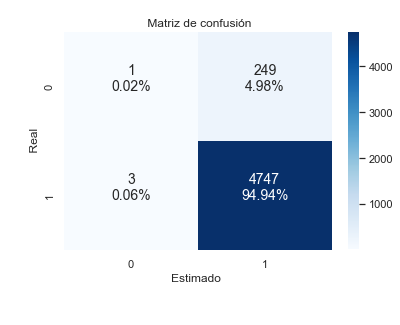

Sensibilidad =  0.004
Especifidad =  0.996
VPP =  0.5
VPN =  0.5


In [33]:
try:
    sensibilidad_0, especifidad_0, VPP_0, VPN_0 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 0)
    print("Sensibilidad = ", sensibilidad_0)
    print("Especifidad = ", especifidad_0)
    print("VPP = ", VPP_0)
    print("VPN = ", VPN_0)
except ZeroDivisionError:
    pass


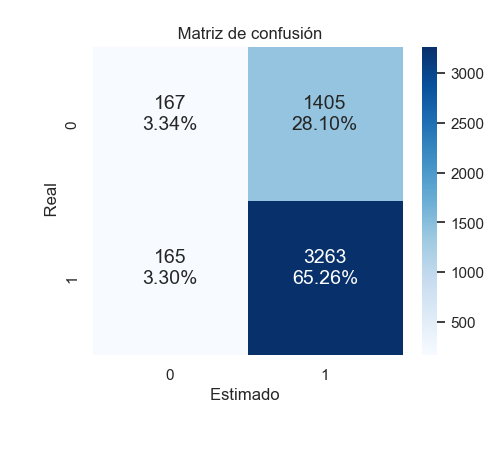

Sensibilidad =  0.12897914379802414
Especifidad =  0.8937659033078881
VPP =  0.5845771144278606
VPN =  0.4695855614973262


In [34]:
try:
    sensibilidad_1, especifidad_1, VPP_1, VPN_1 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 1)
    print("Sensibilidad = ", sensibilidad_1)
    print("Especifidad = ", especifidad_1)
    print("VPP = ", VPP_1)
    print("VPN = ", VPN_1)
except ZeroDivisionError:
    pass

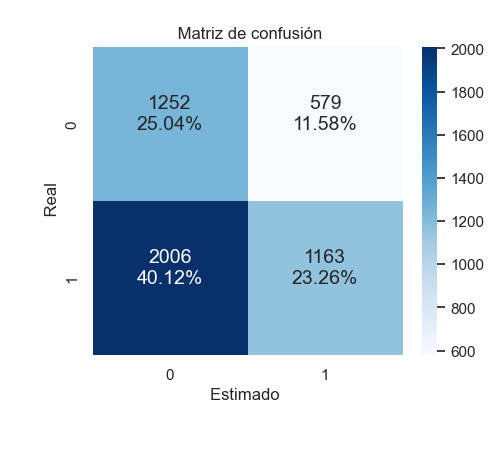

Sensibilidad =  0.7539009033670956
Especifidad =  0.3162206444565811
VPP =  0.6874687968047928
VPN =  0.39174560216508797


In [35]:
try:
    sensibilidad_2, especifidad_2, VPP_2, VPN_2 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 2)
    print("Sensibilidad = ", sensibilidad_2)
    print("Especifidad = ", especifidad_2)
    print("VPP = ", VPP_2)
    print("VPN = ", VPN_2)
except ZeroDivisionError:
    pass

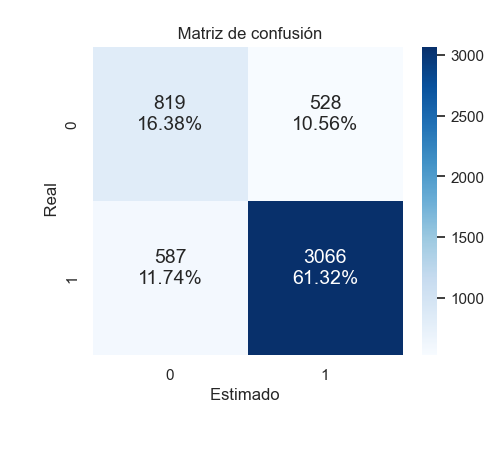

Sensibilidad =  0.2812
Especifidad =  0.39198218262806234
VPP =  0.6319101123595505
VPN =  0.12809315866084425


In [36]:
try:
    sensibilidad_3, especifidad_3, VPP_3, VPN_3 = sens_especif_mat_conf_por_clases(AHI_real_disc, AHI_pred_disc, 3)
    print("Sensibilidad = ", sensibilidad_3)
    print("Especifidad = ", especifidad_3)
    print("VPP = ", VPP_3)
    print("VPN = ", VPN_3)
except ZeroDivisionError:
    pass

# Cálculo de la sensibilidad y especifidad por cada clase o las clases inferiores a ella

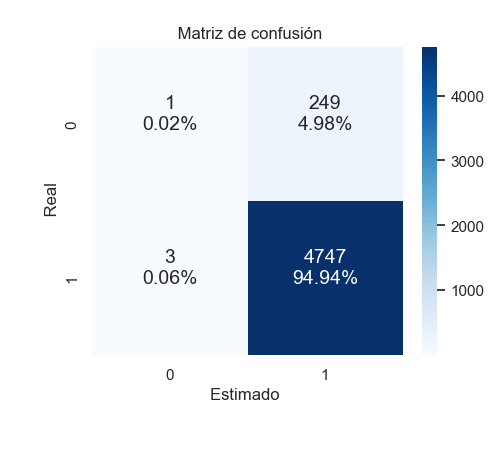

Sensibilidad =  0.004
Especifidad =  0.9993684210526316
VPP =  0.25
VPN =  0.950160128102482


In [37]:
try:
    sensibilidad_0_inf, especifidad_0_inf, VPP_0_inf, VPN_0_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 0)
    print("Sensibilidad = ", sensibilidad_0_inf)
    print("Especifidad = ", especifidad_0_inf)
    print("VPP = ", VPP_0_inf)
    print("VPN = ", VPN_0_inf)
except ZeroDivisionError:
    pass

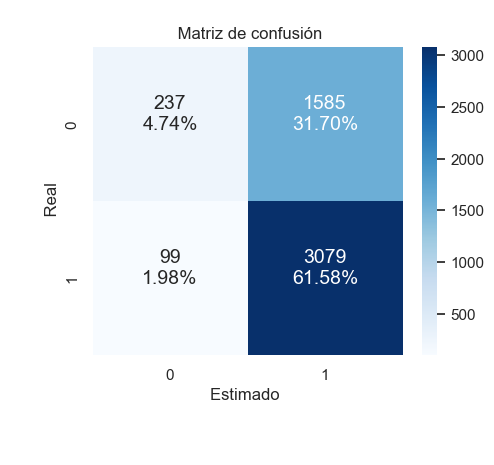

Sensibilidad =  0.1300768386388584
Especifidad =  0.9688483322844557
VPP =  0.7053571428571429
VPN =  0.6601629502572899


In [38]:
try:
    sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 1)
    print("Sensibilidad = ", sensibilidad_1_inf)
    print("Especifidad = ", especifidad_1_inf)
    print("VPP = ", VPP_1_inf)
    print("VPN = ", VPN_1_inf)
except ZeroDivisionError:
    pass

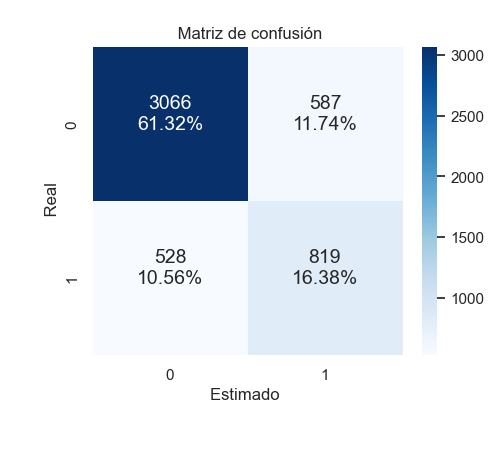

Sensibilidad =  0.8393101560361347
Especifidad =  0.6080178173719376
VPP =  0.8530884808013356
VPN =  0.5825035561877667


In [72]:
try:
    sensibilidad_1_inf, especifidad_1_inf, VPP_1_inf, VPN_1_inf = sens_especif_mat_conf_por_clases_inferiores(AHI_real_disc, AHI_pred_disc, 2)
    print("Sensibilidad = ", sensibilidad_1_inf)
    print("Especifidad = ", especifidad_1_inf)
    print("VPP = ", VPP_1_inf)
    print("VPN = ", VPN_1_inf)
except ZeroDivisionError:
    pass

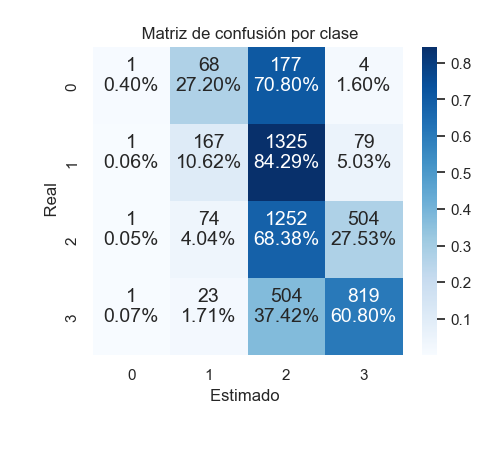

In [40]:
try:
    best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
    cf_mat_row = np.zeros((4,4))
    for i in range(best_cfmatrix_val.shape[0]):
        cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])
    
    group_counts = ["{0:0.0f}".format(value) for value in
            best_cfmatrix_val.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_mat_row.flatten()]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(4,4)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión por clase")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()
except ValueError:
    best_cfmatrix_val = confusion_matrix(AHI_real_disc, AHI_pred_disc)
    cf_mat_row = np.zeros((3,3))
    for i in range(best_cfmatrix_val.shape[0]):
        cf_mat_row[i,:] = best_cfmatrix_val[i]/sum(best_cfmatrix_val[i])
    
    group_counts = ["{0:0.0f}".format(value) for value in
            best_cfmatrix_val.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_mat_row.flatten()]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    plt.rcdefaults()
    sns.set(font_scale=1.4)
    sns.set(rc = {'figure.figsize':(5,4)})

    sns.heatmap(cf_mat_row, annot=labels, annot_kws={"size": 14}, fmt='',  cmap='Blues')

    plt.title("\n Matriz de confusión por clase")
    plt.xlabel("Estimado \n \n \n")
    plt.ylabel("\n \n Real")
    plt.show()
    plt.clf()
    plt.close()